# prelims

In [70]:
from tqdm import tqdm
import copy
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import gymnasium as gym

import seaborn as sns
sns.set_theme(style="whitegrid", font_scale=2)
sns.set_palette("colorblind")
sns.despine()

<Figure size 640x480 with 0 Axes>

In [31]:
from llmicl.rl_helpers import paper_plots 

import importlib
importlib.reload(paper_plots)

<module 'llmicl.rl_helpers.paper_plots' from '/home/abenechehab/llmicl/src/llmicl/rl_helpers/paper_plots.py'>

In [23]:
import torch
from transformers import (
    LlamaForCausalLM, 
    AutoTokenizer
)

tokenizer = AutoTokenizer.from_pretrained(
    # "/home/gpaolo/nas_2/huggingface/hub/models--meta-llama--Meta-Llama-3-8B/snapshots/62bd457b6fe961a42a631306577e622c83876cb6/",
    "/mnt/vdb/hugguingface/hub/models--meta-llama--Llama-3.2-1B/snapshots/5d853ed7d16ac794afa8f5c9c7f59f4e9c950954",
    use_fast=False,
)
print(f"finish loading tokenizer")
model = LlamaForCausalLM.from_pretrained(
    # "/home/gpaolo/nas_2/huggingface/hub/models--meta-llama--Meta-Llama-3-8B/snapshots/62bd457b6fe961a42a631306577e622c83876cb6/",
    "/mnt/vdb/hugguingface/hub/models--meta-llama--Llama-3.2-1B/snapshots/5d853ed7d16ac794afa8f5c9c7f59f4e9c950954",
    device_map="auto",   
    torch_dtype=torch.bfloat16, 
)
print(f"finish loading model")
model.eval()

finish loading tokenizer


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


finish loading model


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=512, bias=False)
          (v_proj): Linear(in_features=2048, out_features=512, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
    (rotary_emb): Ll

In [24]:
state_names = {
    "HalfCheetah": [
        "rootz",
        "rooty",
        "bthigh",
        "bshin",
        "bfoot",
        "fthigh",
        "fshin",
        "ffoot",
        "rootx_dot",
        "rootz_dot",
        "rooty_dot",
        "bthigh_dot",
        "bshin_dot",
        "bfoot_dot",
        "fthigh_dot",
        "fshin_dot",
        "ffoot_dot",
    ],
    "Hopper": [
        "rootz",
        "rooty",
        "thigh",
        "leg",
        "foot",
        "rootx_dot",
        "rootz_dot",
        "rooty_dot",
        "thigh_dot",
        "leg_dot",
        "foot_dot",
    ],
    "Ant": [
        "rootz",
        "root_quat_x",
        "root_quat_y",
        "root_quat_z",
        "root_quat_w",
        "hip_1_angle",
        "ankle_1_angle",
        "hip_2_angle",
        "ankle_2_angle",
        "hip_3_angle",
        "ankle_3_angle",
        "hip_4_angle",
        "ankle_4_angle",
        "rootx_dot",
        "rootz_dot",
        "rooty_dot",
        "root_quat_x_dot",
        "root_quat_y_dot",
        "root_quat_z_dot",
        "hip_1_angle_dot",
        "ankle_1_angle_dot",
        "hip_2_angle_dot",
        "ankle_2_angle_dot",
        "hip_3_angle_dot",
        "ankle_3_angle_dot",
        "hip_4_angle_dot",
        "ankle_4_angle_dot",
    ],
    "Walker2d": [
        "rootz",
        "rooty",
        "thigh_right_angle",
        "leg_right_angle",
        "foot_right_angle",
        "thigh_left_angle",
        "leg_left_angle",
        "foot_left_angle",
        "rootx_dot",
        "rootz_dot",
        "rooty_dot",
        "thigh_right_angle_dot",
        "leg_right_angle_dot",
        "foot_right_angle_dot",
        "thigh_left_angle_dot",
        "leg_left_angle_dot",
        "foot_left_angle_dot",
    ],
    "Swimmer": [
        "rootx",
        "rootz",
        "rooty",
        "joint_1_angle",
        "joint_2_angle",
        "rootx_dot",
        "rootz_dot",
        "rooty_dot",
        "joint_1_angle_dot",
        "joint_2_angle_dot",
    ]
}

action_names = {
    "HalfCheetah": [
        "t_bthigh",
        "t_bshin",
        "t_bfoot",
        "t_fthigh",
        "t_fshin",
        "t_ffoot",
    ],
    "Hopper": [
        "thigh_joint",
        "leg_joint",
        "foot_joint",
    ],
    "Ant": [
        "hip_4_joint",
        "ankle_4_joint",
        "hip_1_joint",
        "ankle_1_joint",
        "hip_2_joint",
        "ankle_2_joint",
        "hip_3_joint",
        "ankle_3_joint",
    ],
    "Walker2d": [
        "thigh_left_joint",
        "leg_left_joint",
        "foot_left_joint",
        "thigh_right_joint",
        "leg_right_joint",
        "foot_right_joint",
    ],
    "Swimmer": [
        "joint_1",
        "joint_2",
    ]
}

new_notation_state = {
'HalfCheetah': [
    r"$rootz$",
    r"$rooty$",
    r"$bthigh$",
    r"$bshin$",
    r"$bfoot$",
    r"$fthigh$",
    r"$fshin$",
    r"$ffoot$",
    r"$\dot{rootx}$",
    r"$\dot{rootz}$",
    r"$\dot{rooty}$",
    r"$\dot{bthigh}$",
    r"$\dot{bshin}$",
    r"$\dot{bfoot}$",
    r"$\dot{fthigh}$",
    r"$\dot{fshin}$",
    r"$\dot{ffoot}$",
],
'Hopper': [
    r"$rootz$",
    r"$rooty$",
    r"$thigh$",
    r"$leg$",
    r"$foot$",
    r"$\dot{rootx}$",
    r"$\dot{rootz}$",
    r"$\dot{rooty}$",
    r"$\dot{thigh}$",
    r"$\dot{leg}$",
    r"$\dot{foot}$",
],
} 

# launch here

In [191]:
all_df_list = []
mean_predictions = []
lb_list = []
ub_list = []
mode_predictions = []
gt_list = []

env_name = 'Hopper'
env = gym.make(env_name)
n_actions = env.action_space.shape[0]
n_observations = env.observation_space.shape[0]
data_label = 'expert'
methods = ['vanilla', 'pca', 'pca', ] # 'ica', 'ica']
# methods = ['pca']
labels = [r'vICL', r'ICL-$(s)$-PCA', r'ICL-$(s,a)$-PCA',] # r'$(s)$-ICA', r'$(s,a)$-ICA']
# labels = [r'ICL-$(s,a)$-PCA']
states_and_actions = [False, False, True]
n_episodes = 3
prediction_horizon = 20
context_length = 400

/home/abenechehab/miniconda3/envs/LLMICL/lib/python3.9/site-packages/gymnasium/envs/registration.py:521: UserWarning: WARN: Using the latest versioned environment `Hopper-v4` instead of the unversioned environment `Hopper`.
  logger.warn(


In [192]:
exp_name = 'hopper_last_minute'
for env_name in ['HalfCheetah']:
    env = gym.make(env_name)
    n_actions = env.action_space.shape[0]
    n_observations = env.observation_space.shape[0]
    all_df_list = []
    mean_predictions = []
    lb_list = []
    ub_list = []
    mode_predictions = []
    gt_list = []
    time_list = []
    for episode in tqdm(range(n_episodes)):
        for method, label, s_and_a in tqdm(zip(methods, labels, states_and_actions), total=len(methods), desc='methods'):
            if method=='vanilla':
                n_components = -1
            else:
                n_components=int((n_observations+n_actions)/2) if s_and_a else int(n_observations/2)
            # for n_components in range(1, n_observations+n_actions+1):
            start = time.time()
            df, all_mean, all_mode, all_lb, all_ub, groundtruth = paper_plots.full_pipeline(
                model=model,
                tokenizer=tokenizer,
                env_name=env_name,
                data_label=data_label,
                episode=episode,
                method=method,
                label=label,  # r'$(s,a)$-ICA',
                states_and_actions=s_and_a,
                n_components=n_components,  # -1
                prediction_horizon=prediction_horizon,
                rescale_factor=7.0,
                up_shift=1.5,
                only_use_context=False,
                context_length=context_length,
                verbose=0
            )
            end = time.time()
            all_df_list.append(df)
            mean_predictions.append(all_mean)
            mode_predictions.append(all_mode)
            lb_list.append(all_lb)
            ub_list.append(all_ub)
            time_list.append(pd.DataFrame(
                [[env_name, episode, method, label, n_components, end-start]], 
                columns=['env', 'episode', 'method', 'label', 'n_components', 'time']
            ))
        gt_list.append(groundtruth)
    all_df = pd.concat(all_df_list, axis=0)
    time_df = pd.concat(time_list, axis=0)
    time_df.to_csv(f'/mnt/vdb/abenechehab/icl_paper/time_full_pipeline_{exp_name}_{env_name}_{data_label}_nep{n_episodes}_predh{prediction_horizon}.csv')
    all_df.to_csv(f'/mnt/vdb/abenechehab/icl_paper/full_pipeline_{exp_name}_{env_name}_{data_label}_nep{n_episodes}_predh{prediction_horizon}.csv')
    with open(f'/mnt/vdb/abenechehab/icl_paper/full_pipeline_{exp_name}_{env_name}_{data_label}_nep{n_episodes}_predh{prediction_horizon}.npy', 'wb') as f:
        np.save(f, np.stack(mean_predictions))
        np.save(f, np.stack(mode_predictions))
        np.save(f, np.stack(lb_list))
        np.save(f, np.stack(ub_list))

/home/abenechehab/miniconda3/envs/LLMICL/lib/python3.9/site-packages/gymnasium/envs/registration.py:521: UserWarning: WARN: Using the latest versioned environment `HalfCheetah-v4` instead of the unversioned environment `HalfCheetah`.
  logger.warn(
methods:   0%|                                                                                                     | 0/3 [00:00<?, ?it/s]/home/abenechehab/llmicl/src/llmicl/interfaces/trainers.py:500: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * (1 + erf((x - true_mean) / (true_sigma * np.sqrt(2))))
/home/abenechehab/llmicl/src/llmicl/legacy/models/ICL.py:563: RuntimeWarning: divide by zero encountered in log
  log_ratio = np.log(self.bin_height_arr) - np.log(Multi_PDF.bin_height_arr)
/home/abenechehab/llmicl/src/llmicl/legacy/models/ICL.py:564: RuntimeWarning: invalid value encountered in multiply
  weighted_log_ratio = log_ratio * self.bin_height_arr * self.bin_width_arr

methods:  33%|██████████████████████████████▋

ValueError: all input arrays must have the same shape

# radar plots

## average error with mean prediction

In [17]:
env_name = 'HalfCheetah'
data_label = 'expert'
n_episodes = 1
prediction_horizon = 50
all_df = pd.read_csv(f'/mnt/vdb/abenechehab/icl_paper/full_pipeline_{env_name}_{data_label}_nep{n_episodes}_predh{prediction_horizon}.csv')
#all_df = pd.read_csv(f'/mnt/vdb/abenechehab/icl_paper/full_pipeline_{env_name}_{data_label}.csv')

In [175]:
all_df

env_name data_label  episode method  states_and_actions  \
0   HalfCheetah     expert        0    pca                True   
0   HalfCheetah     expert        0    pca                True   
0   HalfCheetah     expert        0    pca                True   
0   HalfCheetah     expert        0    pca                True   
0   HalfCheetah     expert        0    pca                True   
..          ...        ...      ...    ...                 ...   
0   HalfCheetah     expert        2    pca                True   
0   HalfCheetah     expert        2    pca                True   
0   HalfCheetah     expert        2    pca                True   
0   HalfCheetah     expert        2    pca                True   
0   HalfCheetah     expert        2    pca                True   

              label  n_components mode_or_mean  prediction_horizon     rootz  \
0   ICL-$(s,a)$-PCA             1         mode                   1  1.572909   
0   ICL-$(s,a)$-PCA             1         mean                   1  1.573700   
0   ICL-$(s,a)$-PCA             1         mode                   2  0.530361   
0   ICL-$(s,a)$-PCA             1         mean                   2  0.664063   
0   ICL-$(s,a)$-PCA             1         mode                   3  0.875057   
..              ...           ...          ...                 ...       ...   
0   ICL-$(s,a)$-PCA            23         mean                 418  1.607630   
0   ICL-$(s,a)$-PCA            23         mode                 419  1.329206   
0   ICL-$(s,a)$-PCA            23         mean                 419  1.608355   
0   ICL-$(s,a)$-PCA            23         mode                 420  0.607614   
0   ICL-$(s,a)$-PCA            23         mean                 420  0.366898   

    ...     ffoot  rootx_dot  rootz_dot  rooty_dot  bthigh_dot  bshin_dot  \
0   ...  0.071713   5.321384   0.371653   0.744239    0.517416   0.675876   
0   ...  0.070819   5.322013   0.370646   0.748115    0.520468   0.676970   
0   ...  0.804814   5.291598   1.420756   1.316560    0.092824   0.319922   
0   ...  0.653733   5.397862   1.250634   0.661486    0.608622   0.504872   
0   ...  1.867806   5.072315   1.695294   0.512457    0.103086   0.099887   
..  ...       ...        ...        ...        ...         ...        ...   
0   ...  1.724663   0.392805   1.180104   0.485864    0.455784   0.351954   
0   ...  1.602785   0.062075   0.590758   0.357176    0.426047   1.084843   
0   ...  1.589318   0.084903   1.366184   0.129728    0.260165   0.527417   
0   ...  1.074493   0.880007   1.113481   0.952244    0.869347   0.591384   
0   ...  1.084761   0.962432   1.132517   0.916885    0.991666   0.270626   

    bfoot_dot  fthigh_dot  fshin_dot  ffoot_dot  
0    1.241198    0.042033   0.837416   0.386958  
0    1.243251    0.043810   0.839365   0.390717  
0    0.359716    0.119944   0.029722   1.512575  
0    0.012662    0.180405   0.359116   0.877223  
0    0.085277    0.239014   1.338925   0.890784  
..        ...         ...        ...        ...  
0    0.032686    0.060956   1.435907   0.549106  
0    0.058385    0.030621   0.702163   1.117376  
0    0.578832    0.432242   0.716785   0.906137  
0    0.303781    0.213114   0.203950   0.778334  
0    0.522601    0.070909   0.125997   0.883605  

[57960 rows x 26 columns]

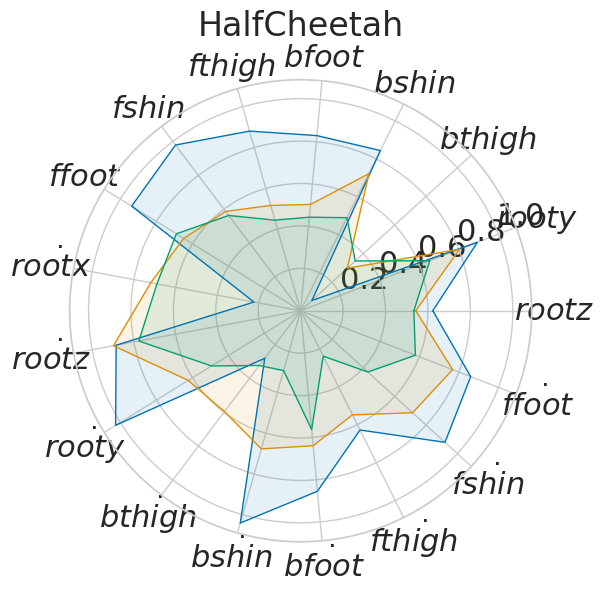

In [193]:
mode_or_mean = 'mean'
h0 = 400
h1 = 420
df_copy = copy.copy(
    all_df.loc[
        (all_df['mode_or_mean']==mode_or_mean) & (all_df['prediction_horizon']>=h0) & (all_df['prediction_horizon']<=h1), ['label']+state_names[env_name]
    ].groupby(['label']).mean().T.reset_index()
)

df_copy['index'] = new_notation_state[env_name]

df_copy = df_copy[df_copy.columns[[0,3,1,2]]]
# df = pd.DataFrame(data)

# Number of variables
categories = list(df_copy['index'])
N = len(categories)

# What will be the angle of each axis in the plot? (we divide the plot / number of variables)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

# Initialise the spider plot
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# First dataset
for label in df_copy.keys():
    if label != 'index':
        values = df_copy[label].tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=1, linestyle='solid', label=label)
        ax.fill(angles, values, alpha=0.1)

# Add labels
plt.xticks(angles[:-1], categories)

# Add a title
plt.title(f'{env_name}')

# Add a legend
# plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.savefig(f'/mnt/vdb/abenechehab/icl_paper/figures/muti_step_radar_{env_name}_halfcomp.pdf', bbox_inches='tight')
plt.show()

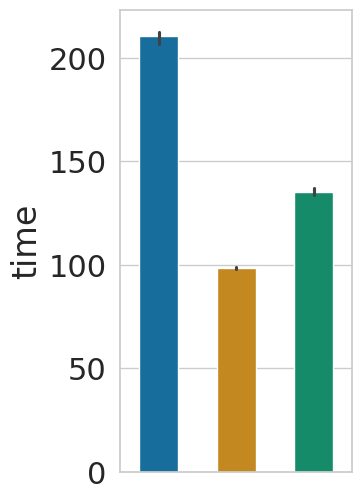

In [139]:
fig, ax = plt.subplots(figsize=(3, 6))
sns.barplot(time_df, x="label", y="time", hue="label", legend=False, ax=ax, width=0.5, hue_order=[r'vICL', r'ICL-$(s)$-PCA', r'ICL-$(s,a)$-PCA'])
ax.set_xticklabels([])
ax.set_xlabel(None)
plt.savefig(f'/mnt/vdb/abenechehab/icl_paper/figures/muti_step_time_{env_name}.pdf', bbox_inches='tight')
plt.show()

In [167]:
with open("/mnt/vdb/abenechehab/icl_paper/baseline_mlp_actions.npy", "rb") as f:
    mlp_actions_pred_all_episodes = np.load(f)
mlp_actions_pred_all_episodes.shape

(23, 17)

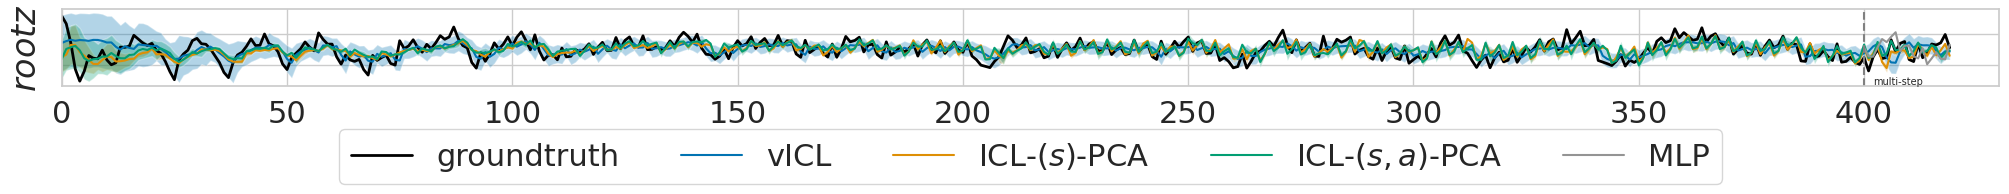

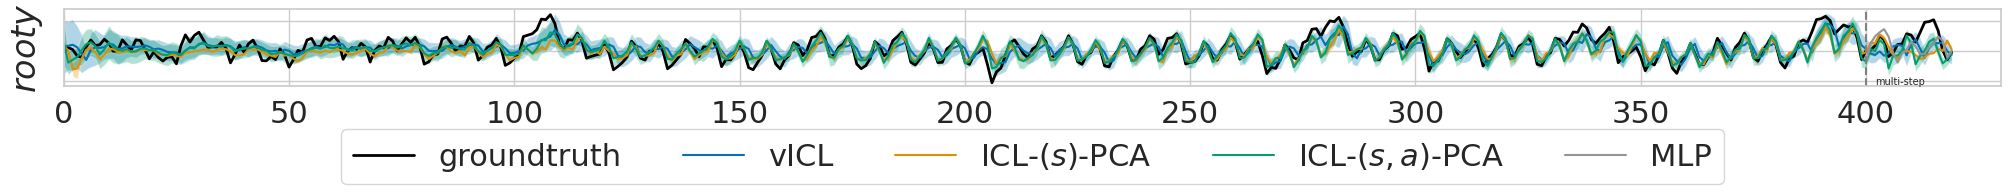

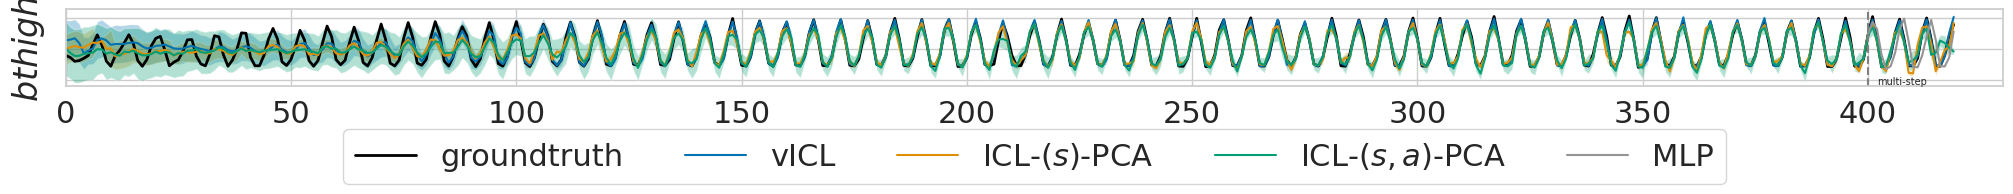

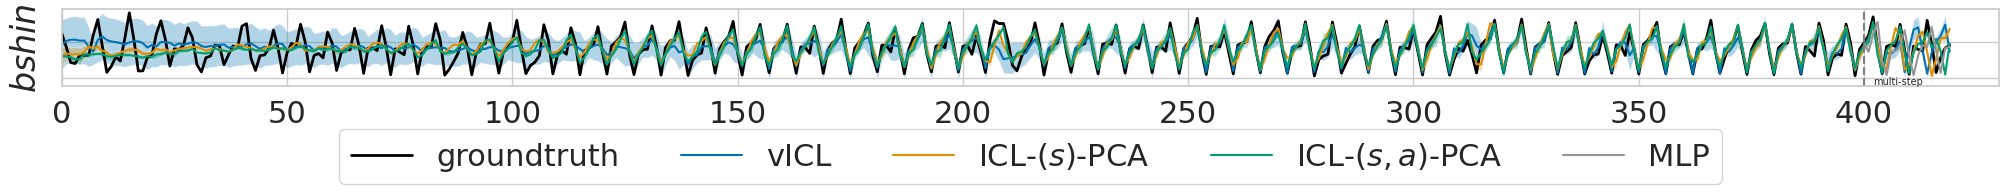

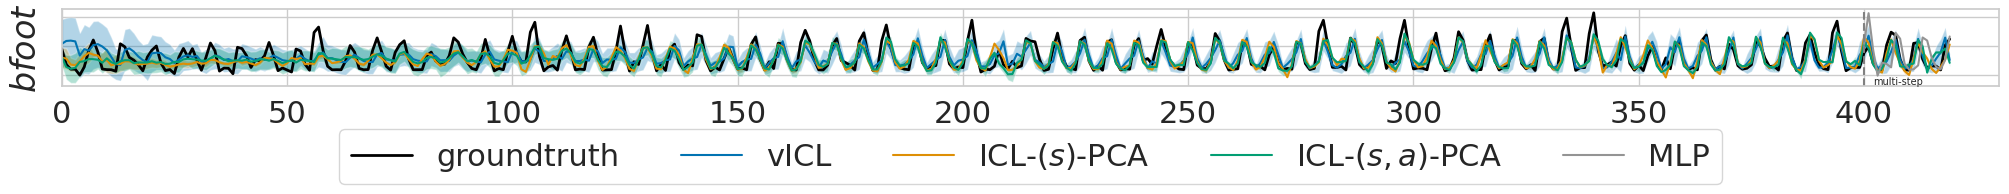

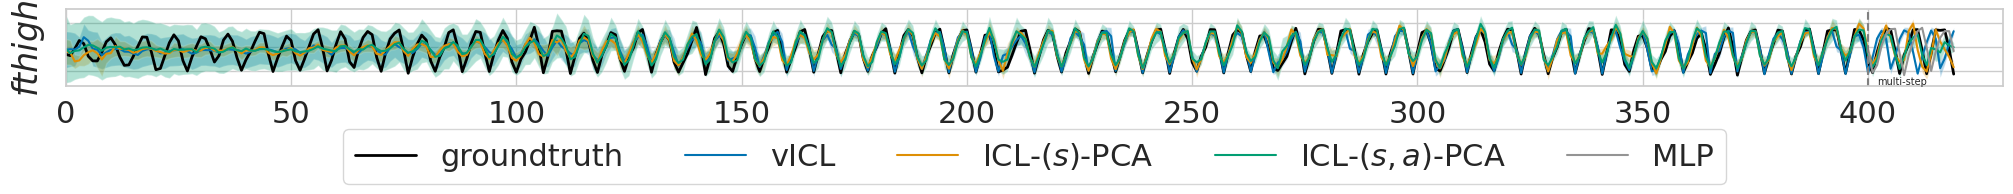

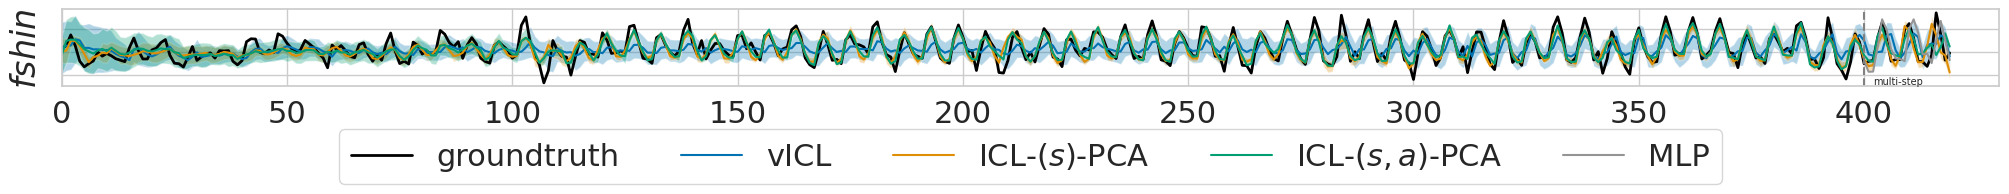

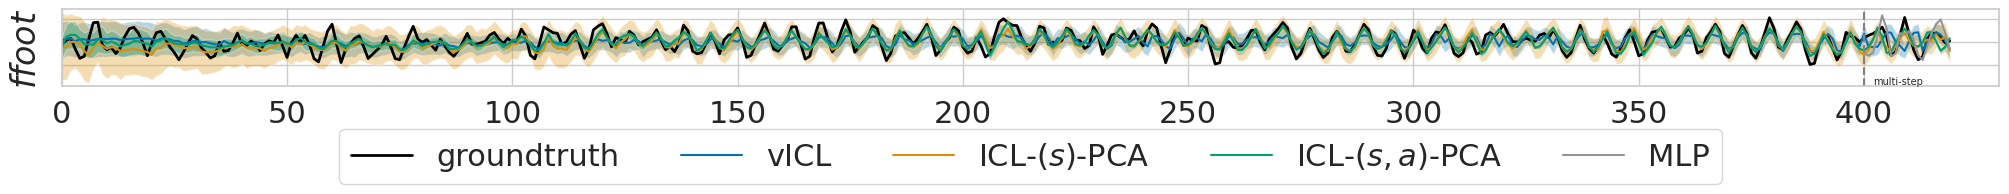

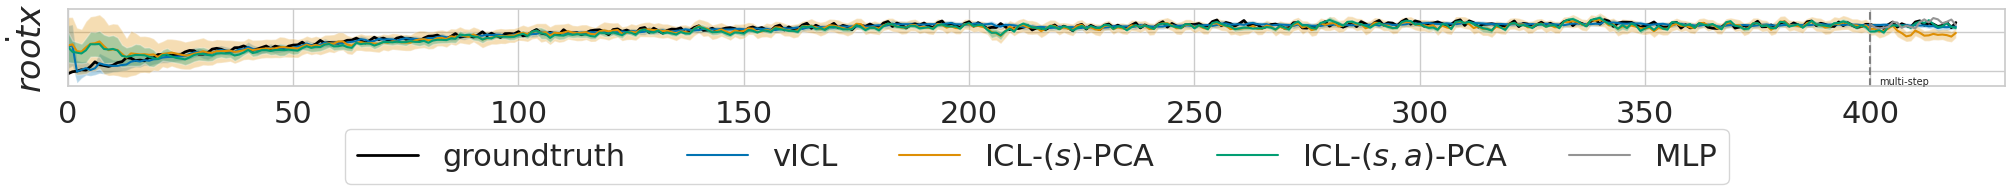

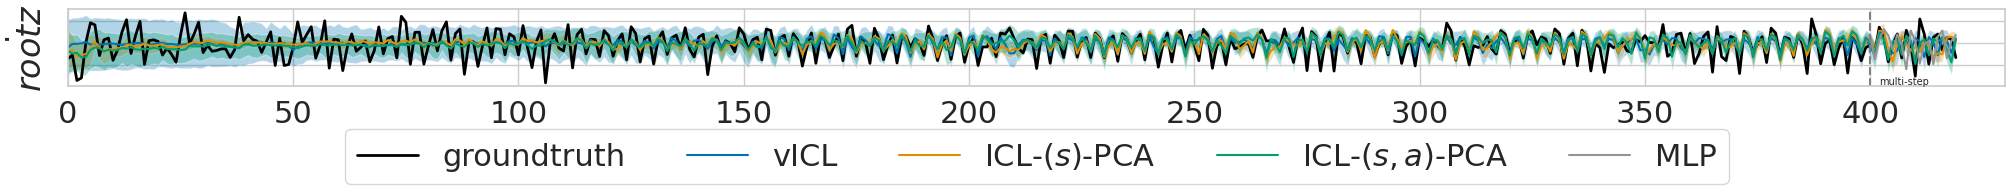

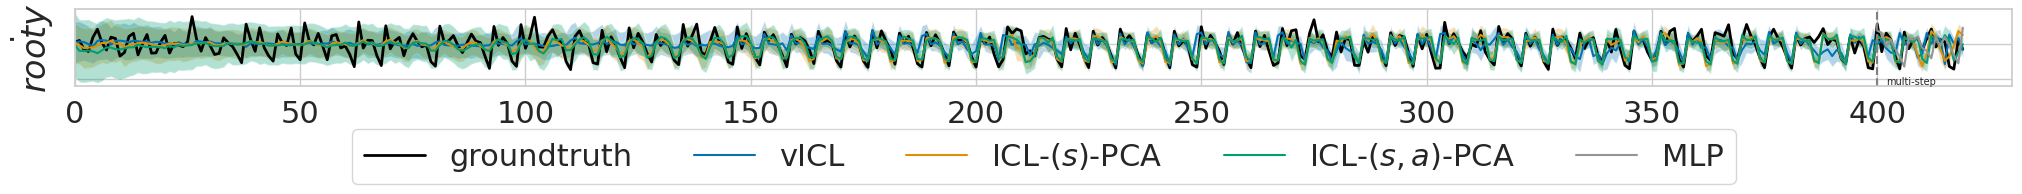

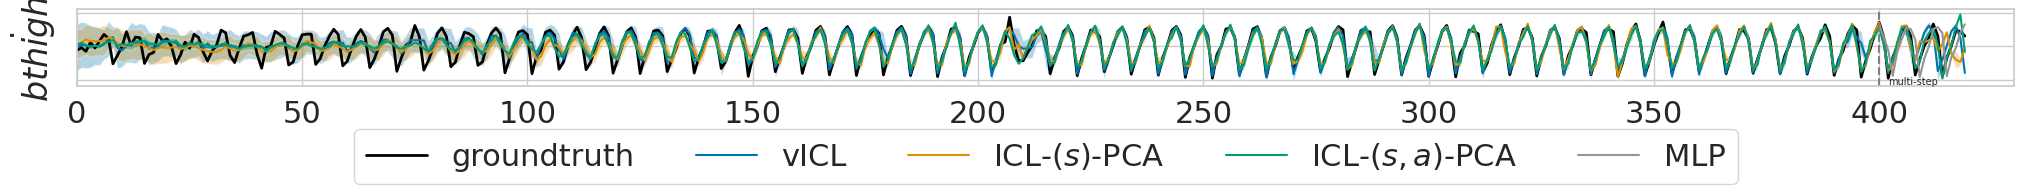

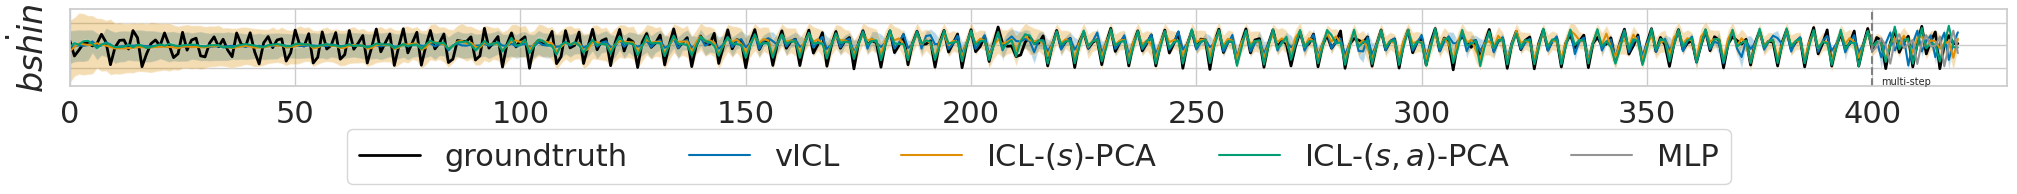

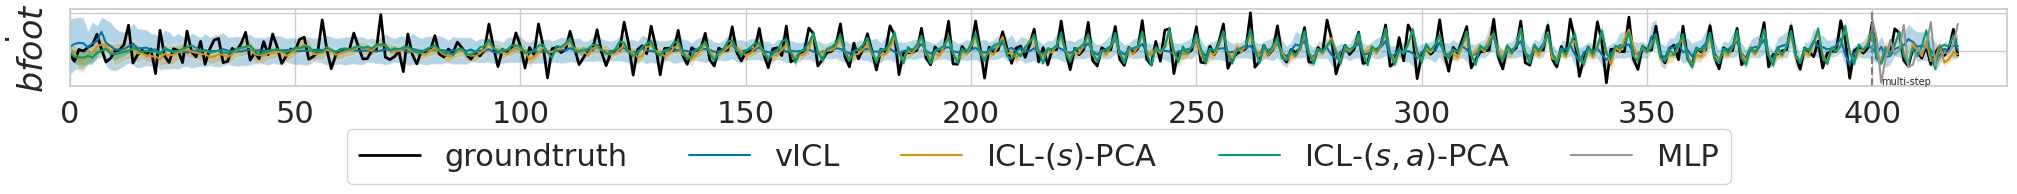

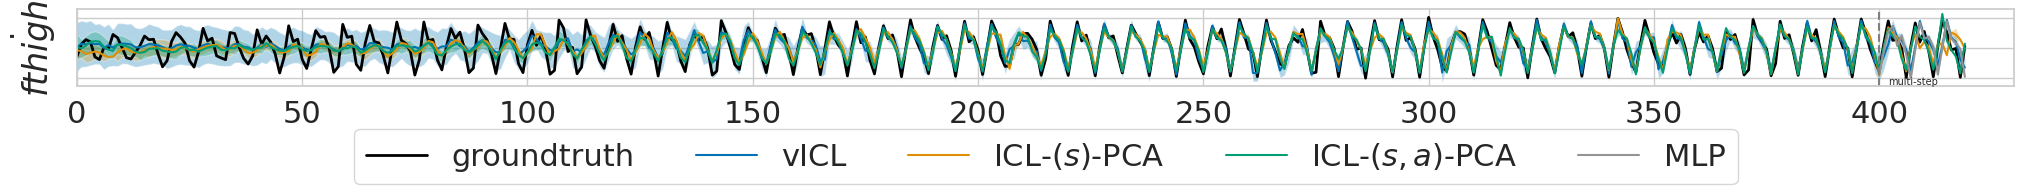

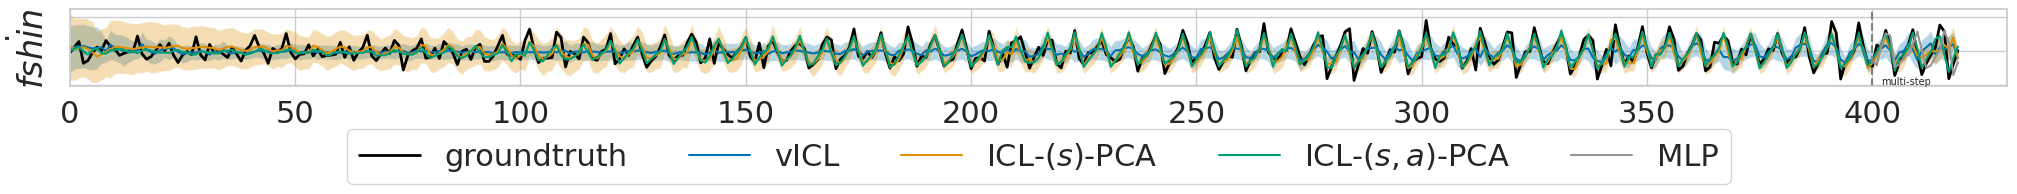

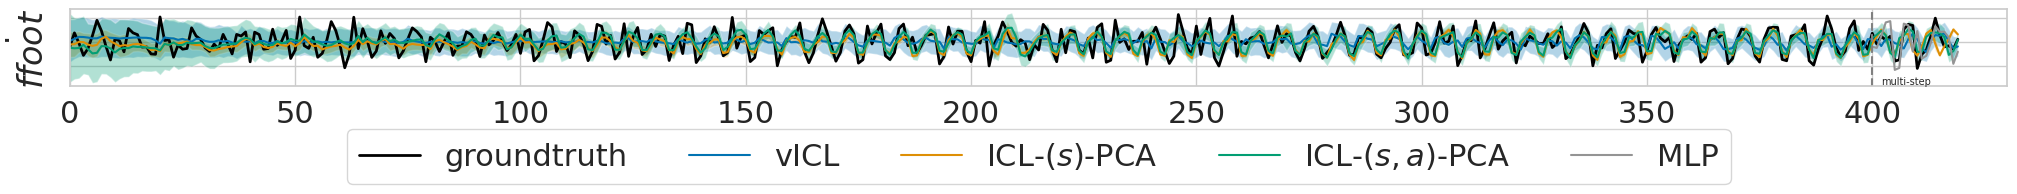

In [194]:
number_of_methods = 3
dim = 1
# for dim in range(17):
for j, dim in enumerate(range(n_observations)): # enumerate([0, 10, 8]):
    f = plt.figure(figsize=(25,1))
    ax = f.add_subplot(111)
    ax.plot(gt_list[-1][:,dim], color='black', linewidth='2', label='groundtruth')
    for i in range(-number_of_methods,0):
        #if i in [-5,-3]:
        ax.plot(mean_predictions[i][:,dim], label=labels[i+number_of_methods])
        ax.fill_between(
            x=np.arange(len(mean_predictions[i][:,dim])), 
            y1=lb_list[i][:,dim], 
            y2=ub_list[i][:,dim],
            alpha=.3
        )
    # baseline
    ax.plot(
        np.arange(len(mean_predictions[i][:,dim]))[-prediction_horizon:], 
        mlp_actions_pred_all_episodes[-prediction_horizon:,dim], 
        color=sns.color_palette("colorblind")[7],
        label=r'MLP'
    )
    ax.axvline(x=context_length, color='grey', linestyle='--')
    # rect = patches.Rectangle((400, ax.get_ylim()[0]), ax.get_xlim()[1], ax.get_ylim()[1]-ax.get_ylim()[0], linewidth=0, edgecolor='none', facecolor='grey', alpha=0.1)
    # ax.add_patch(rect)
    ax.set_ylabel(new_notation_state[env_name][dim])
    ax.set_yticklabels([])
    # ax.ticklabel_format(style='scientific', scilimits=(0,0))
    # if j==0 or j==1:
    # ax.set_xticklabels([])
    ax.set_xlim([0,430])
    ax.text(x=402, y=ax.get_ylim()[0] + 0.02 * (ax.get_ylim()[1]-ax.get_ylim()[0]), s='multi-step', fontsize=7)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=6)
    plt.savefig(f'/mnt/vdb/abenechehab/icl_paper/figures/muti_step_{env_name}_{state_names[env_name][dim]}_h{prediction_horizon}_halfcomp.svg', bbox_inches='tight')
plt.show()

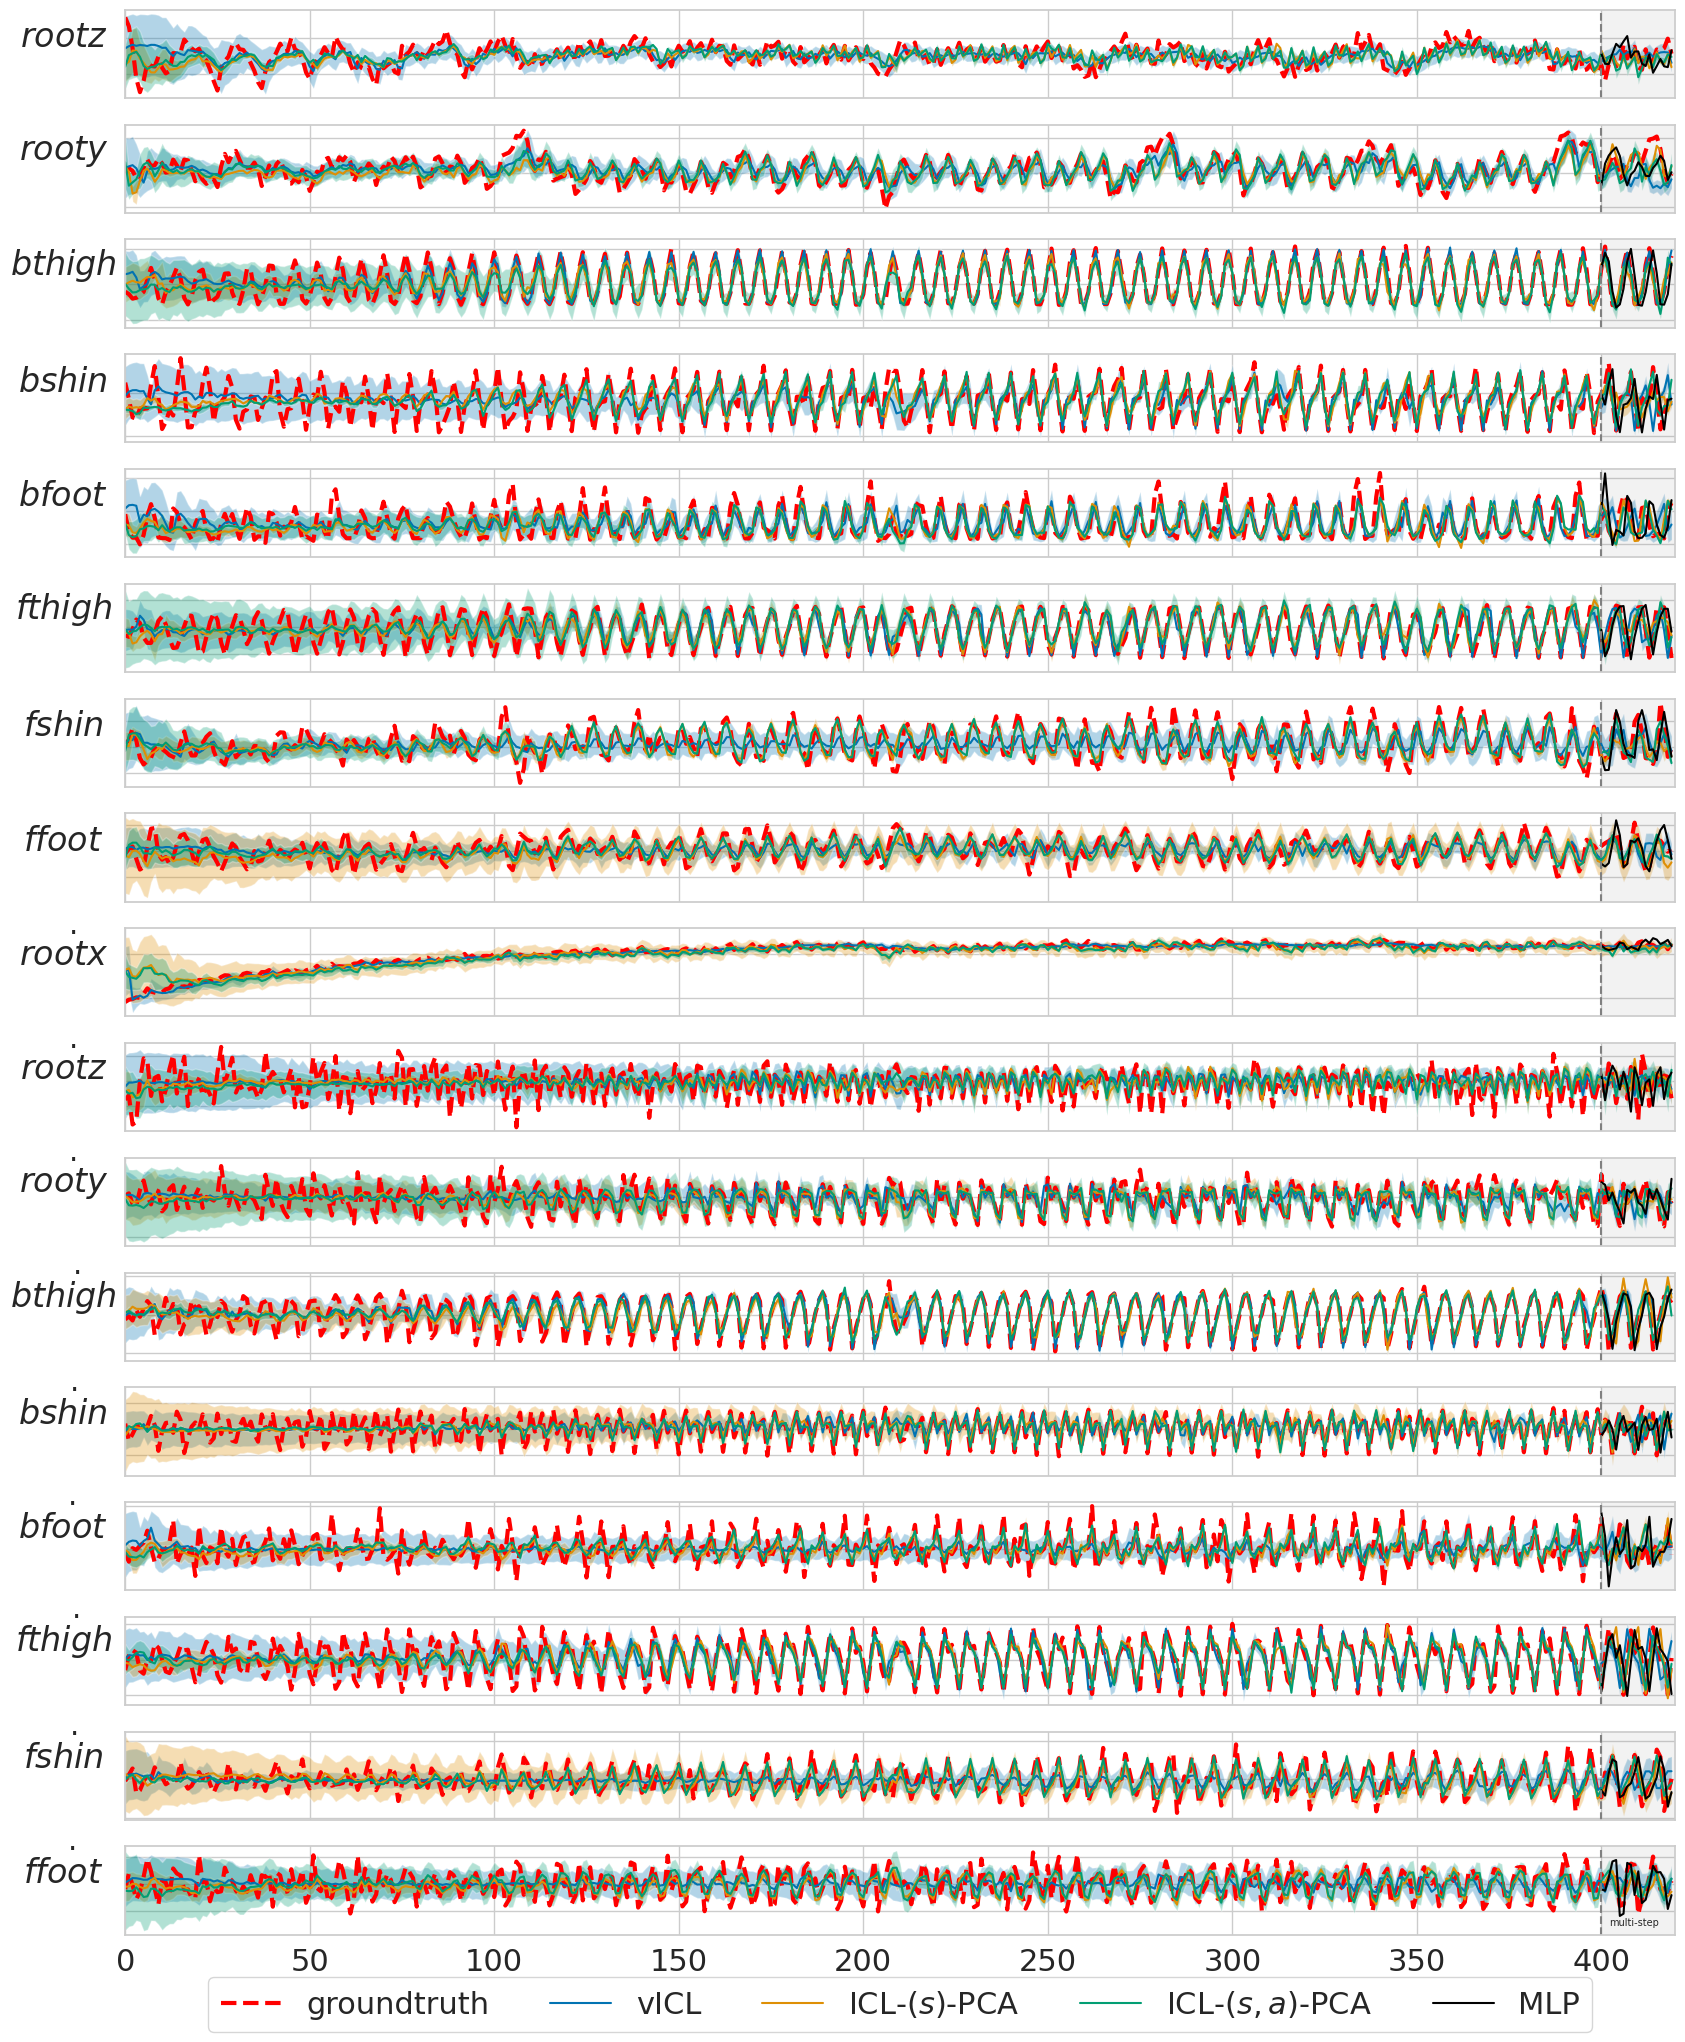

In [169]:
number_of_methods = 3
f, axes = plt.subplots(n_observations, 1, figsize=(20, 25), gridspec_kw={'hspace':0.3}, sharex=True)
axes = list(np.array(axes).flatten())
for j, dim in enumerate(range(n_observations)): # enumerate([0, 10, 8]):
    ax = axes[j]
    ax.plot(np.arange(len(gt_list[-1][:,dim])), gt_list[-1][:,dim], color='red', linewidth='3', label='groundtruth', linestyle='--')
    for i in range(-number_of_methods,0):
        #if i in [-5,-3]:
        ax.plot(np.arange(len(gt_list[-1][:,dim])), mean_predictions[i][:,dim], label=labels[i+number_of_methods])
        ax.fill_between(
            x=np.arange(len(gt_list[-1][:,dim])), 
            y1=lb_list[i][:,dim], 
            y2=ub_list[i][:,dim],
            alpha=.3
        )
    # baseline
    ax.plot(
        np.arange(len(mean_predictions[i][:,dim]))[-prediction_horizon:], 
        mlp_actions_pred_all_episodes[-prediction_horizon:,dim], 
        color='black',
        label=r'MLP'
    )
    ax.set_xlim([0, len(gt_list[-1][:,dim])])
    ax.axvline(x=context_length, color='grey', linestyle='--')
    rect = patches.Rectangle((400, ax.get_ylim()[0]), ax.get_xlim()[1], ax.get_ylim()[1]-ax.get_ylim()[0], linewidth=0, edgecolor='none', facecolor='grey', alpha=0.1)
    ax.add_patch(rect)
    ax.set_ylabel(new_notation_state[env_name][dim], rotation=0, labelpad=35)
    ax.set_yticklabels([])
    # ax.ticklabel_format(style='scientific', scilimits=(0,0))
    # if j==0 or j==1:
    # ax.set_xticklabels([])
ax.text(x=402, y=ax.get_ylim()[0] + 0.1 * (ax.get_ylim()[1]-ax.get_ylim()[0]), s='multi-step', fontsize=7)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=6)
plt.savefig(f'/mnt/vdb/abenechehab/icl_paper/figures/muti_step_{env_name}_alldims_halfcomp.pdf', bbox_inches='tight')
plt.show()

In [177]:
comp = copy.copy(all_df).drop(['env_name', 'data_label', 'method', 'states_and_actions'], axis=1)
comp

episode            label  n_components mode_or_mean  prediction_horizon  \
0         0  ICL-$(s,a)$-PCA             1         mode                   1   
0         0  ICL-$(s,a)$-PCA             1         mean                   1   
0         0  ICL-$(s,a)$-PCA             1         mode                   2   
0         0  ICL-$(s,a)$-PCA             1         mean                   2   
0         0  ICL-$(s,a)$-PCA             1         mode                   3   
..      ...              ...           ...          ...                 ...   
0         2  ICL-$(s,a)$-PCA            23         mean                 418   
0         2  ICL-$(s,a)$-PCA            23         mode                 419   
0         2  ICL-$(s,a)$-PCA            23         mean                 419   
0         2  ICL-$(s,a)$-PCA            23         mode                 420   
0         2  ICL-$(s,a)$-PCA            23         mean                 420   

       rootz     rooty    bthigh     bshin     bfoot  ...     ffoot  \
0   1.572909  1.119269  0.300221  0.007668  0.454781  ...  0.071713   
0   1.573700  1.120295  0.297026  0.003552  0.453571  ...  0.070819   
0   0.530361  0.761229  1.383501  1.520034  1.142856  ...  0.804814   
0   0.664063  0.934511  0.843511  0.824340  0.938315  ...  0.653733   
0   0.875057  0.177300  0.942312  1.251942  0.938044  ...  1.867806   
..       ...       ...       ...       ...       ...  ...       ...   
0   1.607630  1.611159  0.228085  0.295871  0.663586  ...  1.724663   
0   1.329206  0.798613  0.030407  0.312826  0.460389  ...  1.602785   
0   1.608355  0.618316  0.248347  0.112922  0.644745  ...  1.589318   
0   0.607614  0.950175  0.710002  1.118803  0.750655  ...  1.074493   
0   0.366898  0.944578  0.754242  1.052447  0.787273  ...  1.084761   

    rootx_dot  rootz_dot  rooty_dot  bthigh_dot  bshin_dot  bfoot_dot  \
0    5.321384   0.371653   0.744239    0.517416   0.675876   1.241198   
0    5.322013   0.370646   0.748115    0.520468   0.676970   1.243251   
0    5.291598   1.420756   1.316560    0.092824   0.319922   0.359716   
0    5.397862   1.250634   0.661486    0.608622   0.504872   0.012662   
0    5.072315   1.695294   0.512457    0.103086   0.099887   0.085277   
..        ...        ...        ...         ...        ...        ...   
0    0.392805   1.180104   0.485864    0.455784   0.351954   0.032686   
0    0.062075   0.590758   0.357176    0.426047   1.084843   0.058385   
0    0.084903   1.366184   0.129728    0.260165   0.527417   0.578832   
0    0.880007   1.113481   0.952244    0.869347   0.591384   0.303781   
0    0.962432   1.132517   0.916885    0.991666   0.270626   0.522601   

    fthigh_dot  fshin_dot  ffoot_dot  
0     0.042033   0.837416   0.386958  
0     0.043810   0.839365   0.390717  
0     0.119944   0.029722   1.512575  
0     0.180405   0.359116   0.877223  
0     0.239014   1.338925   0.890784  
..         ...        ...        ...  
0     0.060956   1.435907   0.549106  
0     0.030621   0.702163   1.117376  
0     0.432242   0.716785   0.906137  
0     0.213114   0.203950   0.778334  
0     0.070909   0.125997   0.883605  

[57960 rows x 22 columns]

In [180]:
comp['avg_error'] = comp.iloc[:,5:].values.mean(axis=1)
comp = comp.drop(state_names[env_name], axis=1)
comp

episode            label  n_components mode_or_mean  prediction_horizon  \
0         0  ICL-$(s,a)$-PCA             1         mode                   1   
0         0  ICL-$(s,a)$-PCA             1         mean                   1   
0         0  ICL-$(s,a)$-PCA             1         mode                   2   
0         0  ICL-$(s,a)$-PCA             1         mean                   2   
0         0  ICL-$(s,a)$-PCA             1         mode                   3   
..      ...              ...           ...          ...                 ...   
0         2  ICL-$(s,a)$-PCA            23         mean                 418   
0         2  ICL-$(s,a)$-PCA            23         mode                 419   
0         2  ICL-$(s,a)$-PCA            23         mean                 419   
0         2  ICL-$(s,a)$-PCA            23         mode                 420   
0         2  ICL-$(s,a)$-PCA            23         mean                 420   

    avg_error  
0    0.808909  
0    0.809338  
0    1.101466  
0    0.913222  
0    1.017931  
..        ...  
0    0.677547  
0    0.625383  
0    0.678877  
0    0.702530  
0    0.693107  

[57960 rows x 6 columns]

In [182]:
comp = comp.loc[comp['mode_or_mean'] == 'mean'].drop(['mode_or_mean'], axis=1)
comp

episode            label  n_components  prediction_horizon  avg_error
0         0  ICL-$(s,a)$-PCA             1                   1   0.809338
0         0  ICL-$(s,a)$-PCA             1                   2   0.913222
0         0  ICL-$(s,a)$-PCA             1                   3   0.980633
0         0  ICL-$(s,a)$-PCA             1                   4   1.042712
0         0  ICL-$(s,a)$-PCA             1                   5   1.034621
..      ...              ...           ...                 ...        ...
0         2  ICL-$(s,a)$-PCA            23                 416   0.698854
0         2  ICL-$(s,a)$-PCA            23                 417   0.649872
0         2  ICL-$(s,a)$-PCA            23                 418   0.677547
0         2  ICL-$(s,a)$-PCA            23                 419   0.678877
0         2  ICL-$(s,a)$-PCA            23                 420   0.693107

[28980 rows x 5 columns]

In [183]:
h_min = 400
h_max = 420
comp = comp.loc[(comp['prediction_horizon'] <= h_max) & (comp['prediction_horizon'] >= h_min)].drop(['prediction_horizon'], axis=1)
comp

episode            label  n_components  avg_error
0         0  ICL-$(s,a)$-PCA             1   0.855654
0         0  ICL-$(s,a)$-PCA             1   0.615687
0         0  ICL-$(s,a)$-PCA             1   0.771839
0         0  ICL-$(s,a)$-PCA             1   0.681166
0         0  ICL-$(s,a)$-PCA             1   0.547763
..      ...              ...           ...        ...
0         2  ICL-$(s,a)$-PCA            23   0.698854
0         2  ICL-$(s,a)$-PCA            23   0.649872
0         2  ICL-$(s,a)$-PCA            23   0.677547
0         2  ICL-$(s,a)$-PCA            23   0.678877
0         2  ICL-$(s,a)$-PCA            23   0.693107

[1449 rows x 4 columns]

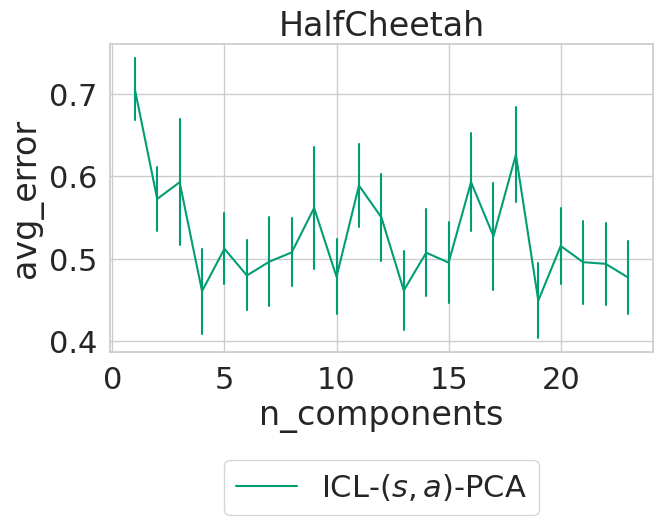

In [190]:
f, ax = plt.subplots(1, 1, figsize=(7,4), gridspec_kw={'hspace':0.3}, sharex=True)
sns.lineplot(
    data=comp, x="n_components", y="avg_error", hue='label', err_style="bars", errorbar=("se", 2), palette=[sns.color_palette("colorblind")[2]], ax=ax
)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=6)
ax.set_title(f'{env_name}')
plt.savefig(f'/mnt/vdb/abenechehab/icl_paper/figures/pca_ablation.pdf', bbox_inches='tight')
plt.show()